In [ ]:
!pip install torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
os.makedirs("generated_images", exist_ok=True)

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latent_dim = 100
batch_size = 128
epochs = 50
lr = 0.0002
print("Using device:", device)

Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check size of one batch
images, _ = next(iter(dataloader))
print("Image batch shape:", images.shape)

100%|██████████| 9.91M/9.91M [00:00<00:00, 51.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.82MB/s]

Image batch shape: torch.Size([128, 1, 28, 28])


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Test shape
G = Generator()
test_noise = torch.randn(1, latent_dim)
print("Generated image shape:", G(test_noise).shape)

Generated image shape: torch.Size([1, 784])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Test shape
D = Discriminator()
print("Output probability shape:", D(torch.randn(1, 784)).shape)

Output probability shape: torch.Size([1, 1])


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

print("Models and optimizers ready.")

Models and optimizers ready.


In [ ]:
for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(real_imgs.size(0), -1).to(device)
        batch_size = real_imgs.size(0)

        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)

        real_loss = loss_fn(discriminator(real_imgs), real)
        fake_loss = loss_fn(discriminator(fake_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        g_loss = loss_fn(discriminator(fake_imgs), real)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

    # Save image every epoch
    with torch.no_grad():
        test_z = torch.randn(64, latent_dim).to(device)
        gen_imgs = generator(test_z).reshape(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(gen_imgs, nrow=8, normalize=True)
        torchvision.utils.save_image(grid, f"generated_images/{epoch+1:03d}.png")


Epoch [1/50]  D_loss: 0.4158  G_loss: 6.9727
Epoch [2/50]  D_loss: 0.0725  G_loss: 5.9247
Epoch [3/50]  D_loss: 5.7771  G_loss: 1.3656
Epoch [4/50]  D_loss: 0.3806  G_loss: 6.0749
Epoch [5/50]  D_loss: 4.0403  G_loss: 1.0019
Epoch [6/50]  D_loss: 0.9519  G_loss: 1.8729
Epoch [7/50]  D_loss: 1.3000  G_loss: 3.3718
Epoch [8/50]  D_loss: 1.6546  G_loss: 1.6157
Epoch [9/50]  D_loss: 0.7386  G_loss: 1.5514
Epoch [10/50]  D_loss: 1.2736  G_loss: 3.1710
Epoch [11/50]  D_loss: 0.3679  G_loss: 3.4057
Epoch [12/50]  D_loss: 0.2559  G_loss: 4.7083
Epoch [13/50]  D_loss: 0.4948  G_loss: 4.3413
Epoch [14/50]  D_loss: 0.5828  G_loss: 2.2774
Epoch [15/50]  D_loss: 0.3179  G_loss: 3.0462
Epoch [16/50]  D_loss: 1.2233  G_loss: 2.1933
Epoch [17/50]  D_loss: 1.4340  G_loss: 3.1491
Epoch [18/50]  D_loss: 1.2220  G_loss: 2.8245
Epoch [19/50]  D_loss: 1.1043  G_loss: 2.4155
Epoch [20/50]  D_loss: 0.5104  G_loss: 3.0453
Epoch [21/50]  D_loss: 1.0265  G_loss: 3.2548
Epoch [22/50]  D_loss: 0.8748  G_loss: 2.13

In [ ]:
!zip -r generated_images.zip generated_images
from google.colab import files
files.download("generated_images.zip")

  adding: generated_images/ (stored 0%)
  adding: generated_images/012.png (deflated 3%)
  adding: generated_images/004.png (deflated 5%)
  adding: generated_images/020.png (deflated 5%)
  adding: generated_images/049.png (deflated 4%)
  adding: generated_images/043.png (deflated 4%)
  adding: generated_images/019.png (deflated 6%)
  adding: generated_images/014.png (deflated 5%)
  adding: generated_images/037.png (deflated 3%)
  adding: generated_images/016.png (deflated 5%)
  adding: generated_images/011.png (deflated 4%)
  adding: generated_images/009.png (deflated 4%)
  adding: generated_images/018.png (deflated 4%)
  adding: generated_images/029.png (deflated 4%)
  adding: generated_images/015.png (deflated 4%)
  adding: generated_images/025.png (deflated 4%)
  adding: generated_images/046.png (deflated 4%)
  adding: generated_images/017.png (deflated 4%)
  adding: generated_images/028.png (deflated 4%)
  adding: generated_images/021.png (deflated 5%)
  adding: generated_images/04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

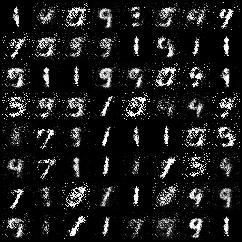

In [ ]:
from IPython.display import Image, display
display(Image("generated_images/049.png"))